In [1]:
import pandas as pd
import pickle
from itertools import permutations
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/trained_models/final_model.pkl', 'rb') as f:
    r_model = pickle.load(f)

with open('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/trained_models/final_classification_model.pkl', 'rb') as f:
    c_model = pickle.load(f)

In [3]:
X_train_c = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/model_input/X_train_val_rekriged.csv').set_index('fire_id', drop=True)
y_train_c = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/model_input/y_train_val_rekriged.csv').set_index(X_train_c.index).iloc[:, 1]
X_train_c.drop(columns=X_train_c.columns[0], inplace=True)

X_test_c = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/model_input/X_test_rekriged.csv', index_col='fire_id').drop(columns='Unnamed: 0')
y_test_c = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/model_input/y_test_rekriged.csv').drop(columns='Unnamed: 0')

X_train_r = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/model_input/X_train_val_rekriged.csv').set_index('fire_id', drop=True)
y_train_r = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/model_input/y_train_val_rekriged.csv').set_index(X_train_r.index).iloc[:, 1]
X_train_r.drop(columns=X_train_r.columns[0], inplace=True)

X_test_r = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/model_input/X_test_rekriged.csv', index_col='fire_id').drop(columns='Unnamed: 0')
y_test_r = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/model_input/y_test_rekriged.csv').drop(columns='Unnamed: 0')

y_train_pred_r = r_model.predict(X_train_r).round(0)
y_train_pred_c = c_model.predict(X_train_c)
y_test_pred_r = r_model.predict(X_test_r).round(0)
y_test_pred_c = c_model.predict(X_test_c)

In [4]:
y_train_r.value_counts()

target_encoded
10    984
0     632
1     621
2     220
3     216
4     202
6     186
5     179
7     163
8     114
9      75
Name: count, dtype: int64

In [5]:
pd.Series(y_train_pred_c).value_counts()

10    1622
0     1044
1      825
3       29
2       28
4       13
6       12
5       12
7        6
8        1
Name: count, dtype: int64

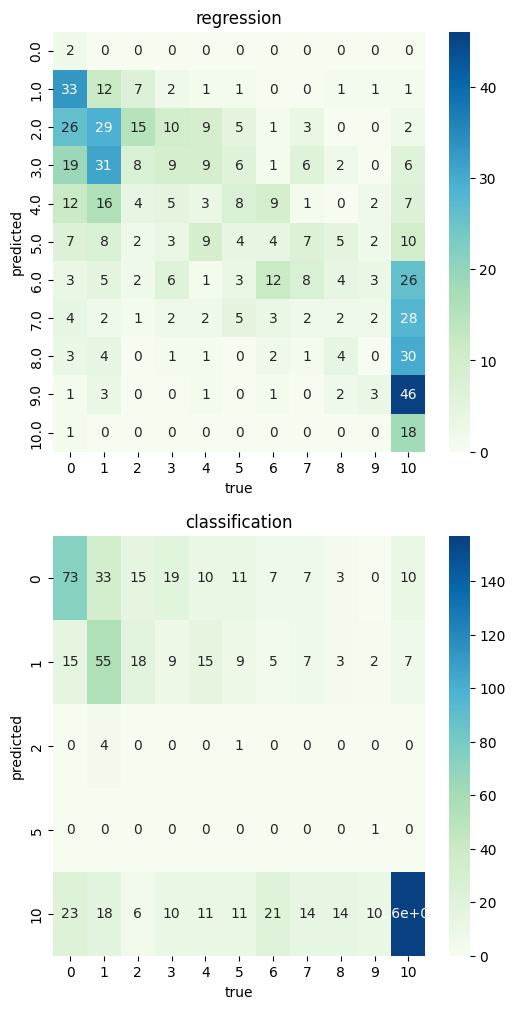

In [6]:
fig, ax = plt.subplots(2,1, figsize=(6,12))
sns.heatmap(pd.crosstab(pd.Series(y_test_pred_r, name='predicted'), pd.Series(np.array(y_test_r['target_encoded']), name='true')), 
                    annot=True, 
                    cmap='GnBu',
                    ax=ax[0]);
ax[0].set_title('regression')
sns.heatmap(pd.crosstab(pd.Series(y_test_pred_c, name='predicted'), pd.Series(np.array(y_test_c['target_encoded']), name='true')), 
            annot=True, 
            cmap='GnBu',
            ax=ax[1]);
ax[1].set_title('classification')
plt.show()

In [7]:
elements = list(range(10))
dispositions = list(permutations(elements, 4))

splits = pd.DataFrame(np.sort(dispositions)).drop_duplicates()

def discretise(val, partition):
    if val <= partition[0]:
        return 0
    elif val <= partition[1]:
        return 1
    elif val <= partition[2]:
        return 2
    elif val <= partition[3]:
        return 3
    elif val <= 10:
        return 4

In [8]:
results = {key: [] for key in ['train_r', 'train_c', 'test_r', 'test_c']}

for idx in tqdm(splits.index, desc='Running splits...'):
    for n, (y_pred, y_true) in enumerate(zip([pd.Series(y_train_pred_r, name='target_encoded'), 
                                              pd.Series(y_train_pred_c, name='target_encoded'), 
                                              pd.Series(y_test_pred_r, name='target_encoded'), 
                                              pd.Series(y_test_pred_c, name='target_encoded')], 
                                              [y_train_r, y_train_c, y_test_r['target_encoded'], y_test_c['target_encoded']])):
        env = list(results.keys())[n]
        pred = y_pred.apply(lambda x: discretise(x, splits.loc[idx, :]))
        true = y_true.apply(lambda x: discretise(x, splits.loc[idx, :]))

        score = accuracy_score(pred, true)
        results[env].append(score)

with open('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/outputs/grid_searches/discretisations.pkl', 'wb') as f:
    pickle.dump(results, f)


Running splits...:   0%|          | 0/210 [00:00<?, ?it/s]

Running splits...: 100%|██████████| 210/210 [10:33<00:00,  3.02s/it]


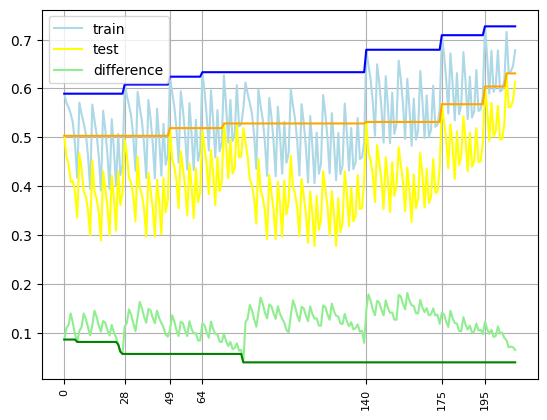

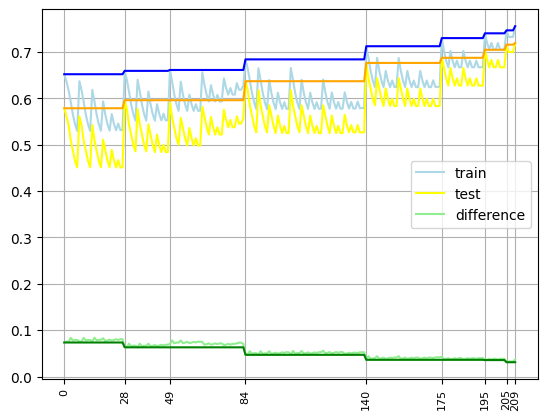

<Figure size 640x480 with 0 Axes>

In [9]:
# with open('/nfs/home/genovese/thesis-wildfire-genovese/ablation_study_zero_image/outputs/grid_searches/discretisations.pkl', 'rb') as f:
#     results = pickle.load(f)

plt.plot(range(splits.shape[0]), results['train_r'], color='lightblue', label='train')
plt.plot(range(splits.shape[0]), results['test_r'], color='yellow', label='test')
plt.plot(range(splits.shape[0]), np.array(results['train_r']) - np.array(results['test_r']), color='lightgreen', label='difference')
plt.plot(range(splits.shape[0]), [np.max(results['train_r'][:n+1]) for n in range(splits.shape[0])], color = 'blue')
plt.plot(range(splits.shape[0]), [np.max(results['test_r'][:n+1]) for n in range(splits.shape[0])], color = 'orange')
plt.plot(range(splits.shape[0]), [np.min((np.array(results['train_r']) - np.array(results['test_r']))[:n+1]) for n in range(splits.shape[0])], color = 'green')
mask = ~pd.Series([np.max(results['train_r'][:n+1]) for n in range(splits.shape[0])]).duplicated()
plt.xticks(pd.Series([np.max(results['train_r'][:n+1]) for n in range(splits.shape[0])]).loc[mask].index)
plt.tick_params('x', labelrotation = 90, labelsize=8)
plt.grid(True)
plt.legend()
ax = plt.gca()
thresholds_r = [int(tick.get_text()) for tick in ax.get_xticklabels()]
plt.show()



plt.clf()
plt.plot(range(splits.shape[0]), results['train_c'], color='lightblue', label='train')
plt.plot(range(splits.shape[0]), results['test_c'], color='yellow', label='test')
plt.plot(range(splits.shape[0]), np.array(results['train_c']) - np.array(results['test_c']), color='lightgreen', label='difference')
plt.plot(range(splits.shape[0]), [np.max(results['train_c'][:n+1]) for n in range(splits.shape[0])], color = 'blue')
plt.plot(range(splits.shape[0]), [np.max(results['test_c'][:n+1]) for n in range(splits.shape[0])], color = 'orange')
plt.plot(range(splits.shape[0]), [np.min((np.array(results['train_c']) - np.array(results['test_c']))[:n+1]) for n in range(splits.shape[0])], color = 'green')
mask = ~pd.Series([np.max(results['train_c'][:n+1]) for n in range(splits.shape[0])]).duplicated()
plt.xticks(pd.Series([np.max(results['train_c'][:n+1]) for n in range(splits.shape[0])]).loc[mask].index)
plt.tick_params('x', labelrotation = 90, labelsize=8)
plt.grid(True)
plt.legend()
ax = plt.gca()
thresholds_c = [int(tick.get_text()) for tick in ax.get_xticklabels()]
plt.show()



plt.clf()

In [10]:
splits.iloc[thresholds_r, ]

,0,1,2,3
0,0,1,2,3
64,0,2,3,4
128,0,3,4,5
192,0,4,5,6
1136,2,3,4,5
1704,3,4,5,6
2272,4,5,6,7


In [27]:
splits.iloc[thresholds_c, ]

,0,1,2,3
0,0,1,2,3
568,1,2,3,4
1136,2,3,4,5
1704,3,4,5,6
2272,4,5,6,7
2840,5,6,7,8
3408,6,7,8,9
